### Authors: Casey Maldonado, Bradley Stoller, Bruna Medeiros, Cicily Matthew, John Melel
### Date: 03/31/2025

# Import Library


In [3]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from collections import Counter

# Data Loading

In [5]:
url = "https://storage.googleapis.com/adsp-nlp-open/data/Food_Inspections_20250325.csv"
df = pd.read_csv(url)

# 1. Select only the records corresponding to failed inspections (see the "results" column).

In [14]:
# Here we filter for failed inspections only
df_failed = df[df['Results'].str.lower() == 'fail'].copy()
df_failed.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
0,1068208,CHINA COURT RESTAURANT,CHINA COURT RESTAURANT,2141795.0,Restaurant,Risk 1 (High),1146 N MILWAUKEE AVE,CHICAGO,IL,60642.0,03/14/2012,License Re-Inspection,Fail,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,41.902462,-87.665306,"(41.902462266949634, -87.66530609467256)"
5,1072529,GRESHAM ELEMENTARY SCHOOL,GRESHAM ELEMENTARY SCHOOL,23451.0,School,Risk 1 (High),8524 S Green (832W),CHICAGO,IL,60620.0,09/05/2013,Canvass,Fail,12. HAND WASHING FACILITIES: WITH SOAP AND SAN...,41.738913,-87.645062,"(41.73891334027122, -87.6450616939937)"
6,1084236,THE JIBARITO STOP,THE JIBARITO STOP,2156722.0,Mobile Food Dispenser,Risk 3 (Low),2007-2009 S DAMEN AVE,CHICAGO,IL,60608.0,05/25/2012,License,Fail,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,41.854695,-87.675765,"(41.854694701707345, -87.67576513516751)"
7,1084239,MANJARES AL EXPRESS,MANJARES AL EXPRESS,2021538.0,Restaurant,Risk 1 (High),2226-2230 S ASHLAND AVE,CHICAGO,IL,60608.0,05/29/2012,Complaint,Fail,2. FACILITIES TO MAINTAIN PROPER TEMPERATURE -...,41.851398,-87.666166,"(41.851397799712196, -87.66616621226514)"
8,1084242,CHISCREAM,CHISCREAM,2152278.0,Mobile Food Dispenser,Risk 3 (Low),324 N LEAVITT ST,CHICAGO,IL,60612.0,06/04/2012,License,Fail,"1. SOURCE SOUND CONDITION, NO SPOILAGE, FOODS ...",41.887434,-87.681849,"(41.88743405025222, -87.68184949426895)"


# 2. Use regular expressions to extract the regulation description and inspector comments from the "violations" columns.

In [15]:
def extract_violations(text):
    if pd.isnull(text):
        return []
    
    violations = text.split('|')
    result = []
    for v in violations:
        v = v.strip()
        match = re.match(r'^\s*(\d+)\.\s*(.*?)(?:\s*-\s*Comments:\s*(.*))?$', v, re.IGNORECASE)
        if match:
            code = match.group(1).strip()
            desc = match.group(2).strip()
            comment = match.group(3).strip() if match.group(3) else ''
            result.append((code, desc, comment))
    return result

In [16]:
df_failed["Parsed_Violation"] = df_failed["Violations"].apply(extract_violations)
df_failed = df_failed.explode("Parsed_Violation")

In [17]:
df_failed[['DBA Name', 'Parsed_Violation']].head(10)

,DBA Name,Parsed_Violation
0,CHINA COURT RESTAURANT,"(18, NO EVIDENCE OF RODENT OR INSECT OUTER OPE..."
0,CHINA COURT RESTAURANT,"(32, FOOD AND NON-FOOD CONTACT SURFACES PROPER..."
0,CHINA COURT RESTAURANT,"(41, PREMISES MAINTAINED FREE OF LITTER, UNNEC..."
5,GRESHAM ELEMENTARY SCHOOL,"(12, HAND WASHING FACILITIES: WITH SOAP AND SA..."
5,GRESHAM ELEMENTARY SCHOOL,"(18, NO EVIDENCE OF RODENT OR INSECT OUTER OPE..."
5,GRESHAM ELEMENTARY SCHOOL,"(34, FLOORS: CONSTRUCTED PER CODE, CLEANED, GO..."
6,THE JIBARITO STOP,"(18, NO EVIDENCE OF RODENT OR INSECT OUTER OPE..."
6,THE JIBARITO STOP,"(32, FOOD AND NON-FOOD CONTACT SURFACES PROPER..."
6,THE JIBARITO STOP,"(34, FLOORS: CONSTRUCTED PER CODE, CLEANED, GO..."
7,MANJARES AL EXPRESS,"(2, FACILITIES TO MAINTAIN PROPER TEMPERATURE,..."


In [9]:
df_failed[['Code_Number', 'Violation_Description', 'Violation_Comment']] = pd.DataFrame(
    df_failed['Parsed_Violation'].tolist(), index=df_failed.index
)

In [10]:
df_failed[['DBA Name', 'Parsed_Violation', 'Code_Number', 'Violation_Description', 'Violation_Comment']].head(3)

,DBA Name,Parsed_Violation,Code_Number,Violation_Description,Violation_Comment
0,CHINA COURT RESTAURANT,"(18, NO EVIDENCE OF RODENT OR INSECT OUTER OPE...",18,NO EVIDENCE OF RODENT OR INSECT OUTER OPENINGS...,"FOUND NO PEST CONTROL LOG BOOK ON PREMISES,FRO..."
0,CHINA COURT RESTAURANT,"(32, FOOD AND NON-FOOD CONTACT SURFACES PROPER...",32,FOOD AND NON-FOOD CONTACT SURFACES PROPERLY DE...,SPLASHGUARD AT FRONT EXPOSED HANDSINK IS MISSI...
0,CHINA COURT RESTAURANT,"(41, PREMISES MAINTAINED FREE OF LITTER, UNNEC...",41,"PREMISES MAINTAINED FREE OF LITTER, UNNECESSAR...","DETAIL CLEAN,ORGANIZE REAR STORAGE AREAS AND R..."


# 3. Count how many times each regulation description occurred in the table and visualize the top 10 most frequent regulation descriptions.

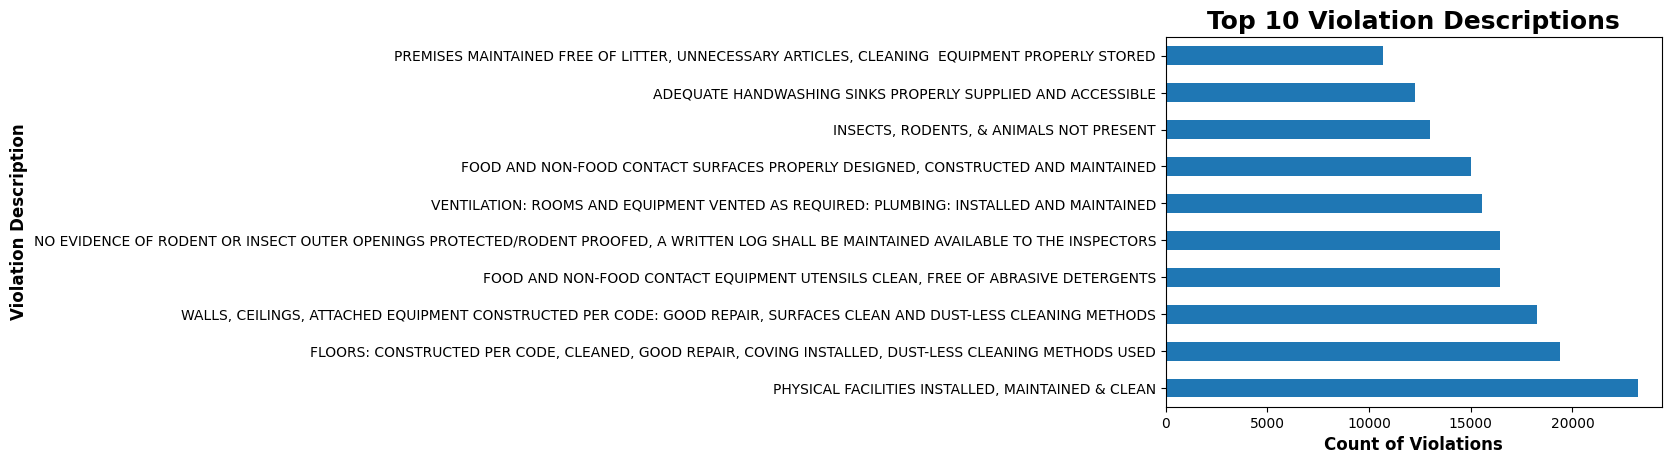

In [11]:
top_violations = df_failed['Violation_Description'].value_counts().iloc[:10]

top_violations.plot(kind= 'barh')
plt.xlabel('Count of Violations', fontsize= 12, fontweight= 'bold')
plt.ylabel('Violation Description', fontsize= 12, fontweight= 'bold')
plt.title('Top 10 Violation Descriptions', fontsize= 18, fontweight= 'bold')
plt.show()

# 4. Tokenize the comments and provide a count of the top 10:
   1. Raw tokens
   2. Preprocessed tokens
   3. Preprocessed tokens + Porter stemmer
   4. Preprocessed tokens + Lancaster stemmer
   5. Preprocessed tokens + lemmatization
   
Briefly describe the differences in various tokens from (4).

In [12]:
porter = nltk.PorterStemmer()
lancaster = nltk.LancasterStemmer()
lemmatizer = nltk.WordNetLemmatizer()

In [13]:
def get_wordnet_pos(treebank_tag, skip_value="n"):
    """Converts treebank tags to WordNet tags."""
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return skip_value

In [14]:
comments = df_failed["Violation_Comment"].dropna()
comments = comments[comments.apply(lambda x: isinstance(x, str))]
text = ' '.join(comments)

In [15]:
raw_tokens = word_tokenize(text)

In [16]:
stop_words = set(stopwords.words('english'))
preprocessed = [
    token.lower()
    for token in raw_tokens
    if token.isalpha() and token.lower() not in stop_words
]

In [17]:
porter_stemmed = [porter.stem(token) for token in preprocessed]

In [18]:
lancaster_stemmed = [lancaster.stem(token) for token in preprocessed]

In [19]:
tagged = pos_tag(preprocessed)
lemmatized = [lemmatizer.lemmatize(token, get_wordnet_pos(pos)) for token, pos in tagged]

In [21]:
tokenized_component_names = [
    "Raw Tokens",
    "Preprocessed",
    "Porter Stemmed",
    "Lancaster Stemmed",
    "Lemmatized"
]

tokenized_components = [
    raw_tokens,
    preprocessed,
    porter_stemmed,
    lancaster_stemmed,
    lemmatized
]

In [ ]:
ranked_columns = {}

for name, tokens in zip(tokenized_component_names, tokenized_components):
    top_tokens = Counter(tokens).most_common(10)
    ranked_columns[name] = [f"{token}" for token, count in top_tokens]

ranked_df = pd.DataFrame(ranked_columns)
ranked_df.index += 1
ranked_df.index.name = "Rank"

ranked_df

,Raw Tokens,Preprocessed,Porter Stemmed,Lancaster Stemmed,Lemmatized
Rank,,,,,
1,.,must,food,food,food
2,AND,instructed,must,must,must
3,",",food,area,cle,area
4,THE,observed,instruct,instruct,clean
5,IN,clean,clean,observ,instruct
6,TO,area,observ,are,maintain
7,OF,maintain,maintain,maintain,sink
8,MUST,prep,sink,prep,floor
9,ON,sink,floor,sink,observe


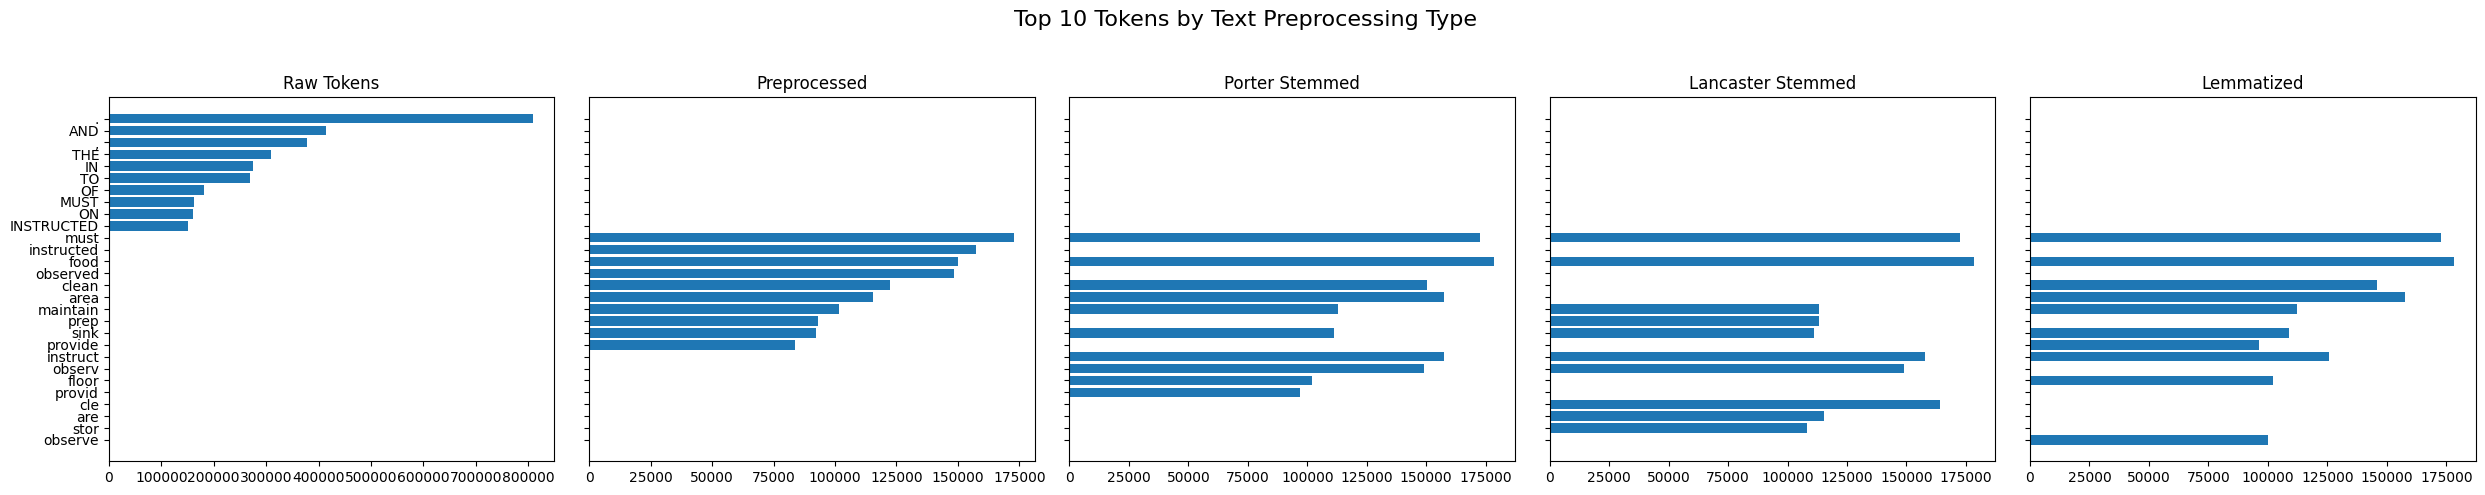

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 5), sharey=True)
fig.suptitle("Top 10 Tokens by Text Preprocessing Type", fontsize=16)

for ax, name, tokens in zip(axes, tokenized_component_names, tokenized_components):
    top = Counter(tokens).most_common(10)
    labels, counts = zip(*top)
    ax.barh(labels, counts)
    ax.set_title(name)
    ax.invert_yaxis()

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle
plt.show()


# 5. Briefly describe the differences in various tokens from (4).

From the table and chart above, we see that the main difference between the raw tokens and the other tokens (preprocessed, porter stemmed, lancaster stemmed, and lemmatized) is the captilization, since the text from the original dataset was all upper case. Additionally, we further see that many of the top tokens in the raw tokens are words like "AND", "THE, and "TO", which are common stop words. Thus, it makes sense that these are not included in the preprocessed tokens. 

After preprocessing, we see that meaningful, non stop words exist such as "must", "food", and "instructed" appear. With the porter and lancaster we see that many of the words are simplified, for example "clean" becoming "cle" and "provide" becoming "provid". However, with the lemmatized words, we see that the words are still readable, but just in their base forms, such as "must", "instruct" and "provide".


Ultimately, the progression of how these words changed throughout the tokenization process highlights the importance of preprocessing, and serves as a good indicator of the most notable comment insights from the restaurant violations.